# Multi-Dimension Scaling (MDS)

Distance-preserving manifold learning method. All manifold learning algorithms assume the dataset lies on a smooth, non linear manifold of low dimension and that a mapping f: $R^{D}$ -> $R^{d}$ (D>>d) can be found by preserving one or more properties of the higher dimension space. Distance preserving methods assume that a manifold can be defined by the pairwise distances of its points. In distance preserving methods, a low dimensional embedding is obtained from the higher dimension in such a way that pairwise distances between the points remain same. Some distance preserving methods preserve spatial distances (MDS) while some preserve graph distances.

MDS is not a single method but a family of methods. MDS takes a dissimilarity matrix $D$ where $D_{ij}$ represents the dissimilarity between points $i$ and $j$ and produces a mapping on a lower dimension, preserving the dissimilarities as closely as possible. The dissimilarity matrix could be observed or calculated from the given dataset.

MDS can be divided into two categories:

- **Metric MDS** - Metric MDS is used for quantitative data and tries to preserve the original dissimilarity metrics.

- **Non-Metric MDS** - Non-metric MDS is used for ordinal data. It tries to keep the order of dissimialrity metrics intact.

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing. To keep things simple, here’s a brief overview of working of t-SNE:

- The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

- It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.

- To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using a gradient descent method.


In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by identifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.

I recommend to familiarize with this amazing blogpost https://distill.pub/2016/misread-tsne/ which graphically shows traps associated with use of t-SNE and how  hyperparameters selection can  affect final embeding.



### To better illustrate properties of individual methods of reducing dimensionality (from this and previous lab), create a set of points in the shape of a roulade.  To do it:

1. Prepare a point generator for the circles in this generator, ensure that the radius decreases with the next steps (in this way you will get a spiral)

2. Treat the spiral as a cross-sectional solid, creating a croissant / crescent roll

3. Move the points in the roll with a slight noise to avoid their perfect placement

4. For better visualization, you can give individual points a color depending, e.g. on the distance from the center of the roulade

5. Generated roulade should resemble the picture below

In [1]:
from time import time
import math
import random
import glob

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras

sn.set(color_codes=True)
np.random.seed(1234)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [20, 20]



## Roulade points generator

In [2]:
def random_spiral_point(density=2):
    p = random.random()**0.5
    return p*math.cos(p*density*np.pi*2), p*math.sin(p*density*np.pi*2)

def uniform_spiral(density=3, steps = 100):
    x, y = [] ,[]
    for i in range(steps):
        x.append((i/steps)**0.5*math.cos((i/steps)**0.5*density*np.pi*2))
        y.append((i/steps)**0.5*math.sin((i/steps)**0.5*density*np.pi*2))

    return x, y

def spiral2roll(xli, yli, width=7, angle=0.1):
    nx, ny, nz, d = [], [], [], []
    for x,y in zip(xli, yli):
        p = random.random()
        nx.append((width+x)*math.cos(angle*p*np.pi*2))
        ny.append((width+x)*math.sin(angle*p*np.pi*2))
        nz.append(y)
        d.append((x**2+y**2)**0.5)
    return nx, ny, nz, d

def uniform_roll(xli, yli, width=7, angle=0.25, density=5, noise_factor=0.05):
    nx, ny, nz, d = [], [], [], []
    d1 = [((x**2+y**2)**0.5) for x,y in zip(xli, yli)]
    for i in range(density):
        nx.extend([(width+x)*math.cos(angle*i/density*np.pi*2) + (random.random()-0.5)*noise_factor for x in xli])
        ny.extend([(width+x)*math.sin(angle*i/density*np.pi*2) + (random.random()-0.5)*noise_factor  for x in xli])
        nz.extend(yli)
        d.extend(d1)
    return nx, ny, nz, d


def roll_generator(to_array=True, spiral_density=3, spiral_steps = 20, width=7, angle=0.3, density=5):
    x, y = uniform_spiral(density=spiral_density, steps = spiral_steps)
    x,y,z,d = uniform_roll(x, y, width=width, angle=angle, density=density)

    if to_array:
        return np.array([x,y,z]).T, d
    else:
        return x,y,z,d


In [3]:
def plot_roulade(x,y,z,d=None):
    fig = plt.figure()
    fig.set_size_inches(8,6)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])


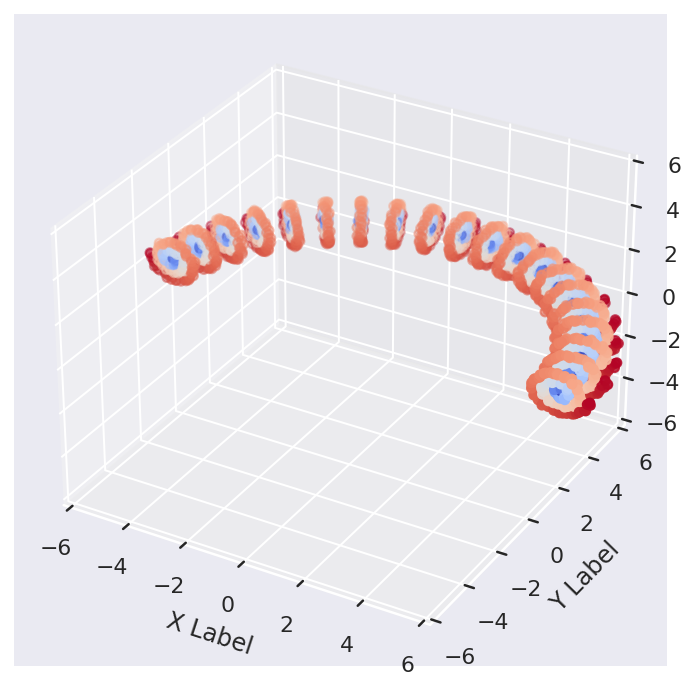

In [4]:
xl, yl = uniform_spiral()
x,y,z,d = uniform_roll(xl,yl, width=7, angle=0.5, density=20, noise_factor=0.15)
plot_roulade(x,y,z,d=d)

#### Visualize the prepared set of points by projecting onto a 2D plane, changing the following aspects in subsequent approaches:

1. Density of points generated, in terms of points per spiral

2. Distance between roll layers, layer density

3. Visualization method: PCA, KernelPCA, MDS, t-SNE

4. generate at least a few plots per method


#### Save each generated chart, you will later need it to embeding images

#### PCA implementation

In [5]:
def show_PCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2)
    points_transformed = embedding.fit_transform(points)

    points_transformed_t = points_transformed.T

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')


    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'pca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

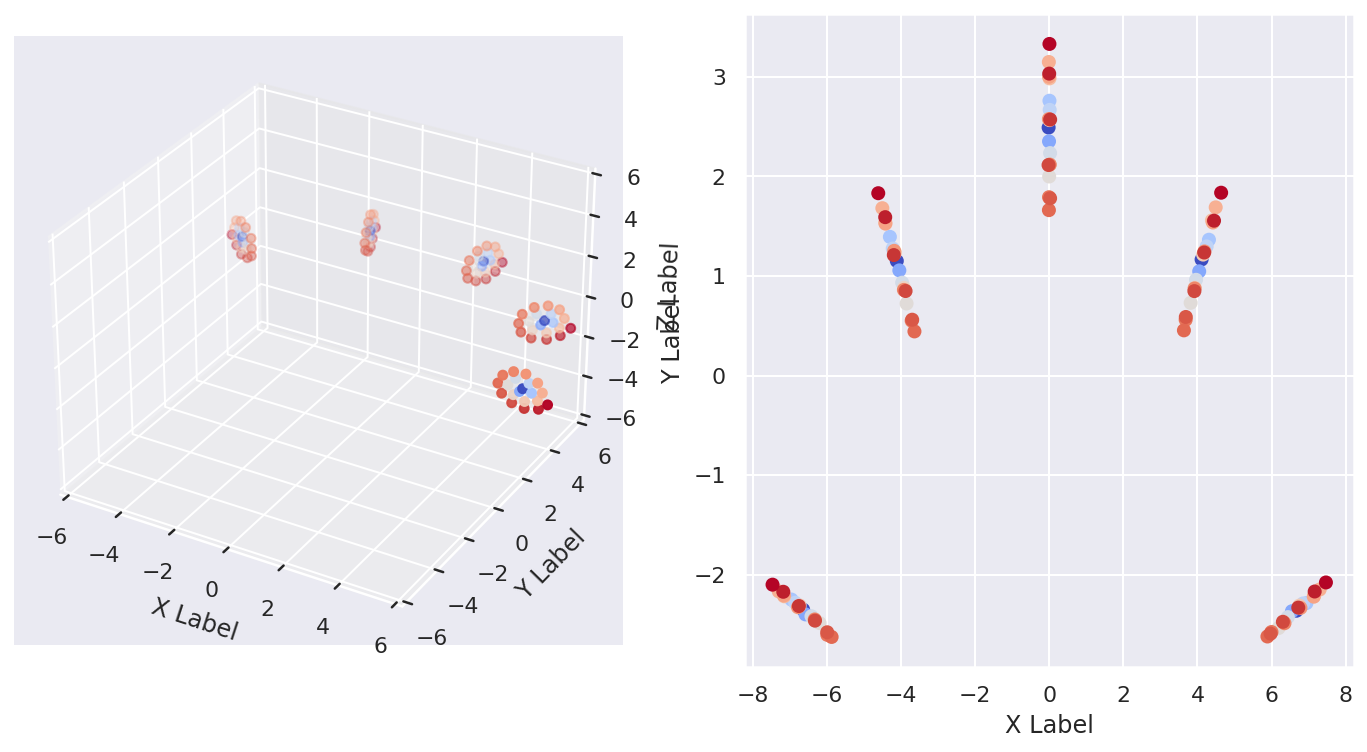

In [6]:
show_PCA() # default settings

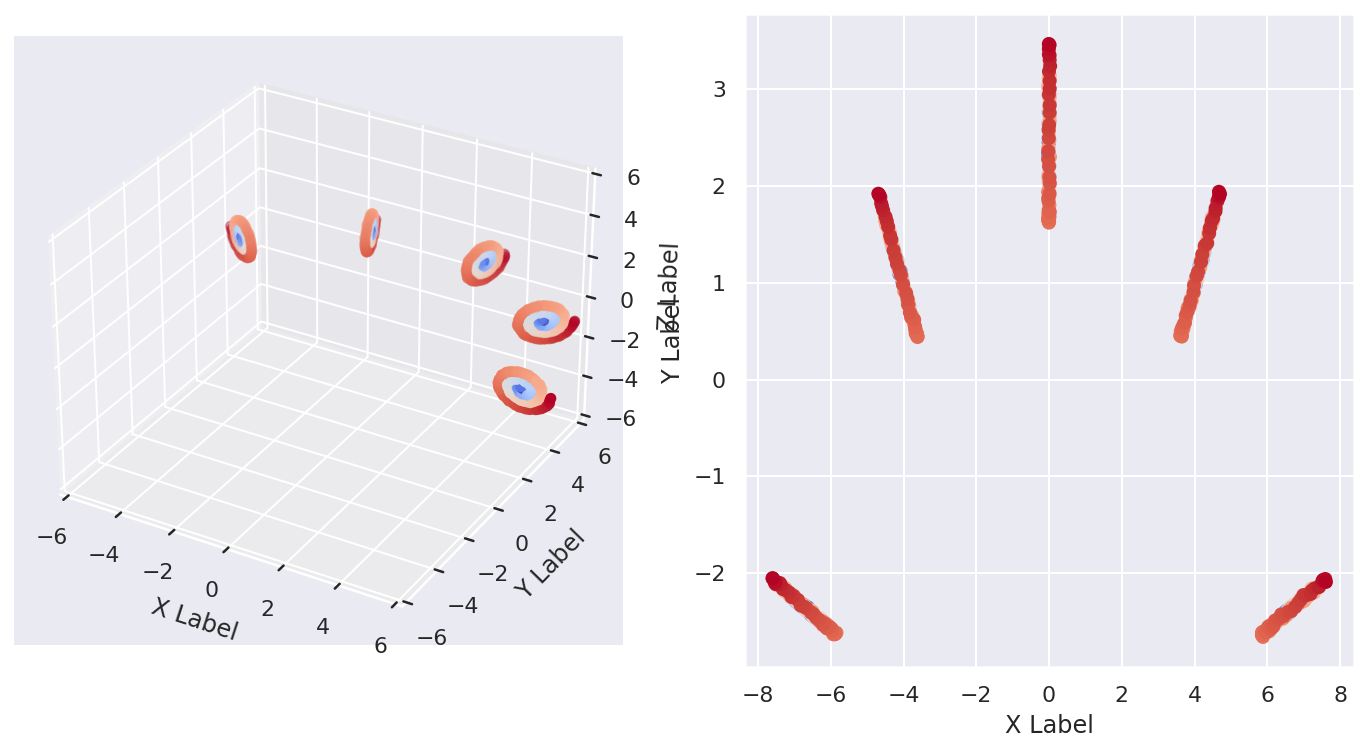

In [7]:
show_PCA(spiral_steps = 100) # zwiększa tylko gęstość zbioru, mało ciekawe i raczej nie bedzie analizowane w kolejnych punktach

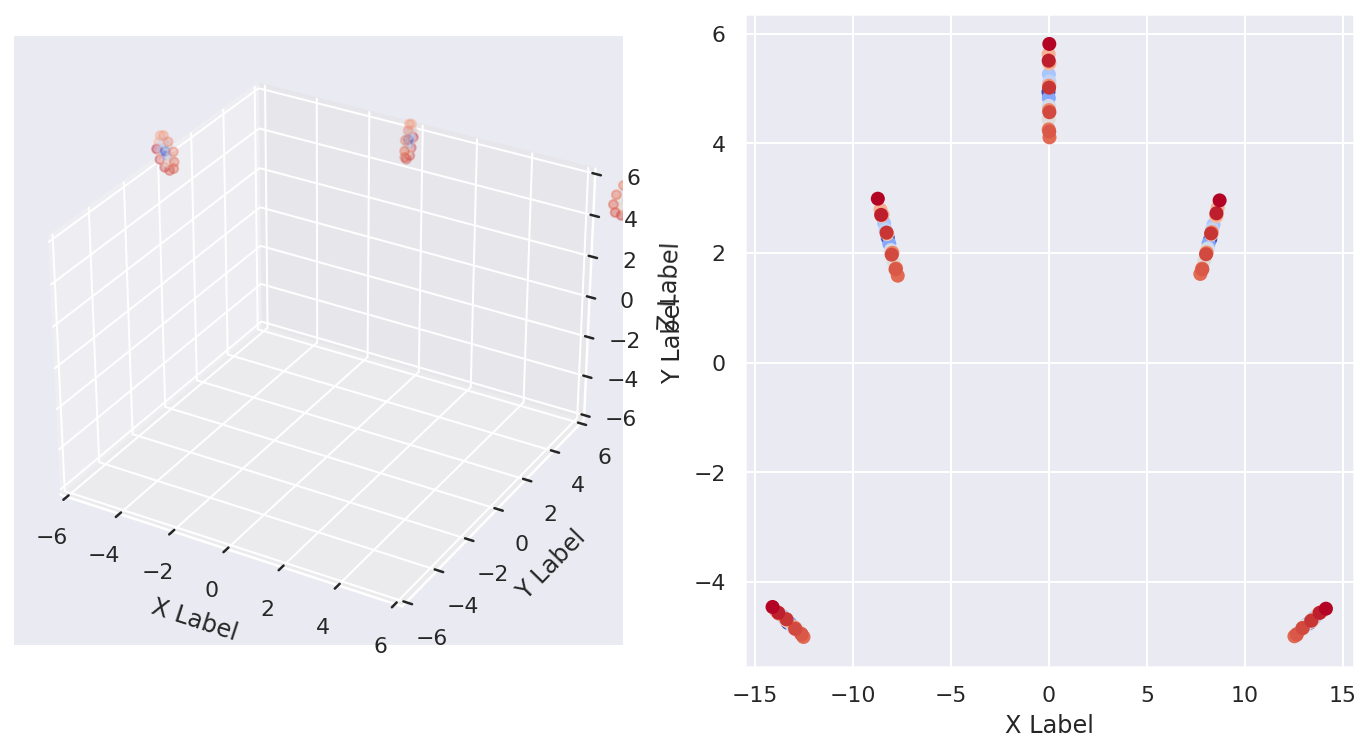

In [8]:
show_PCA(width=14) # oddala okręgi w roladzie od siebie, również mało ciekawe

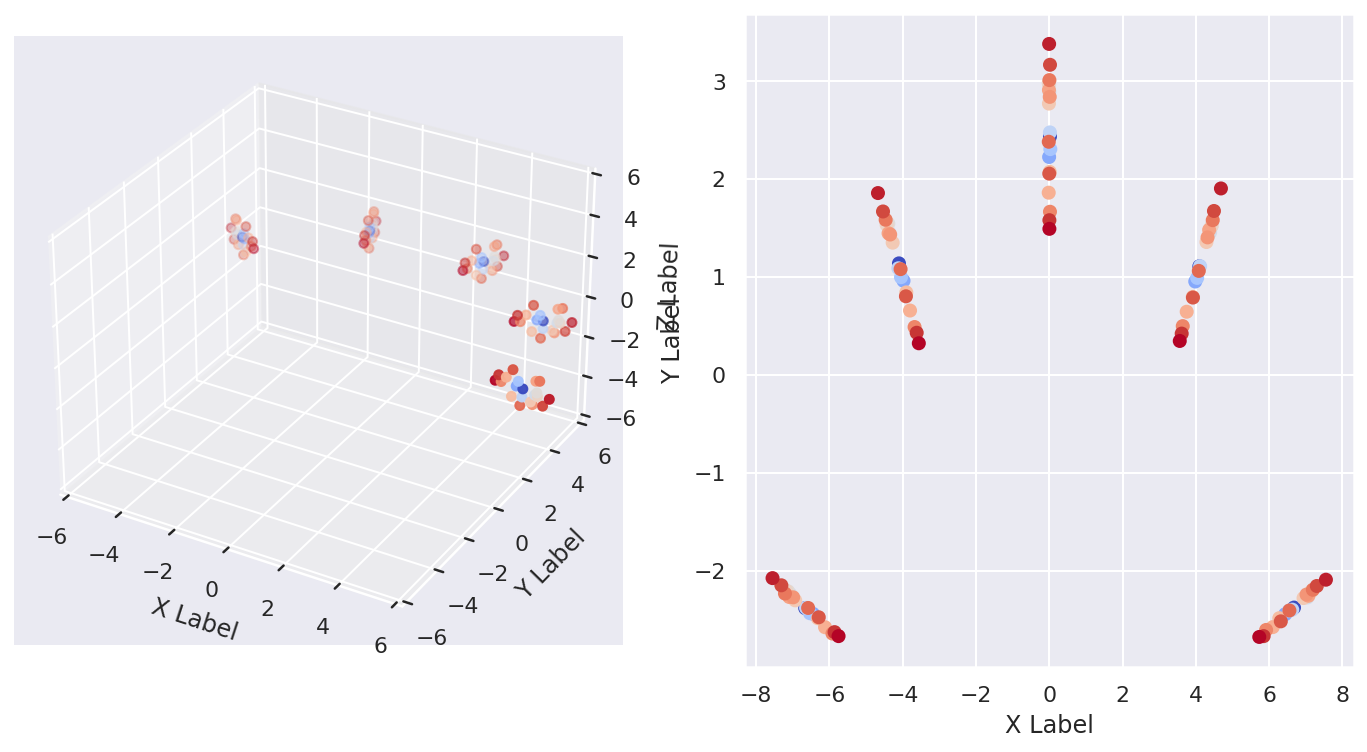

In [9]:
show_PCA(spiral_density=20)
# duże "density" (niefortunna nazwa, bo tak naprawdę to jest sparsity - im. większe tym bardziej rozrzucone prążki)
# sprawia, że po zrzuceniu do dwóch wymiarów też mamy bardziej rozrzucone próbki

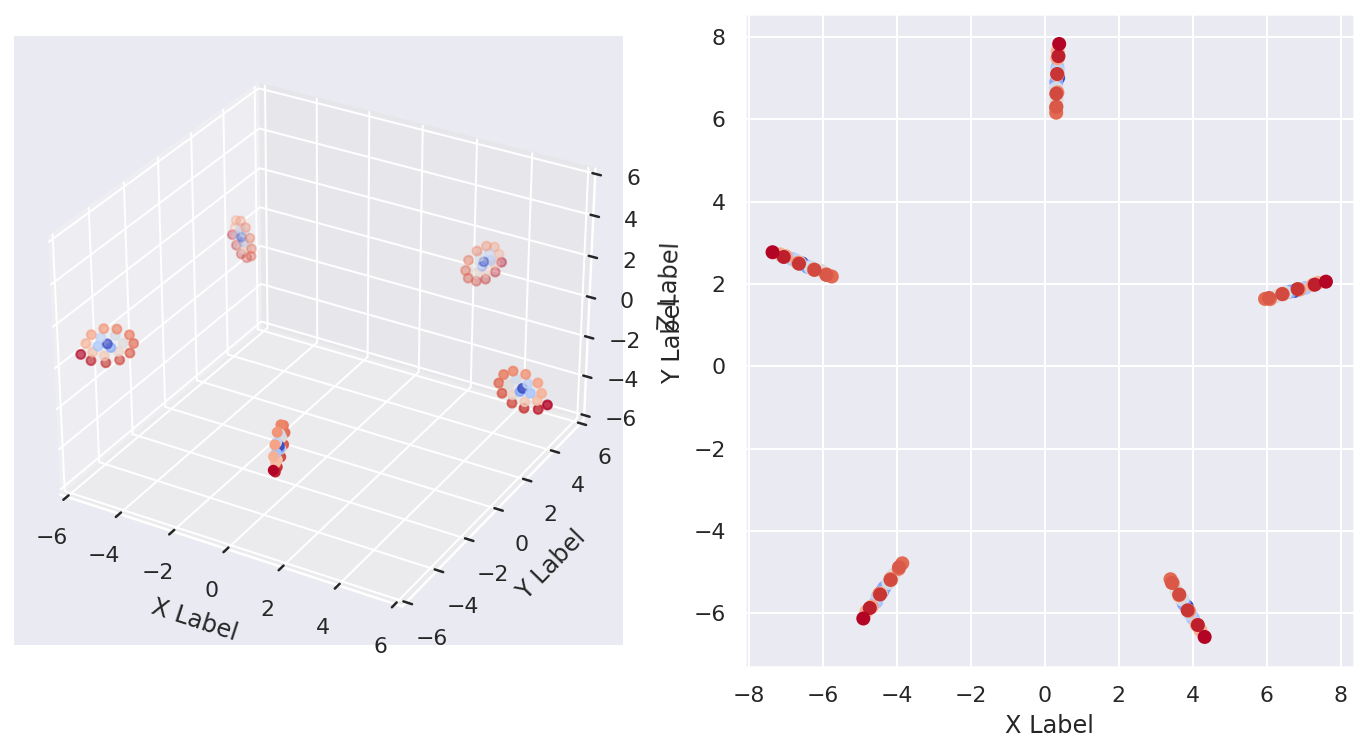

In [10]:
show_PCA(angle=2) # rozrzucenie prążków w przestrzeni sprawia, że rzut rozkłada się tak samo w 2D,
#tutaj ewidentnie widać, że PCA robi nam praktycznie rzut prostopadły na płaszcyznę

#### KernelPCA implementation

In [11]:
def show_KernelPCA(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.decomposition import KernelPCA
    embedding = KernelPCA(n_components=2)
    points_transformed = embedding.fit_transform(points)

    points_transformed_t = points_transformed.T

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'kpca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

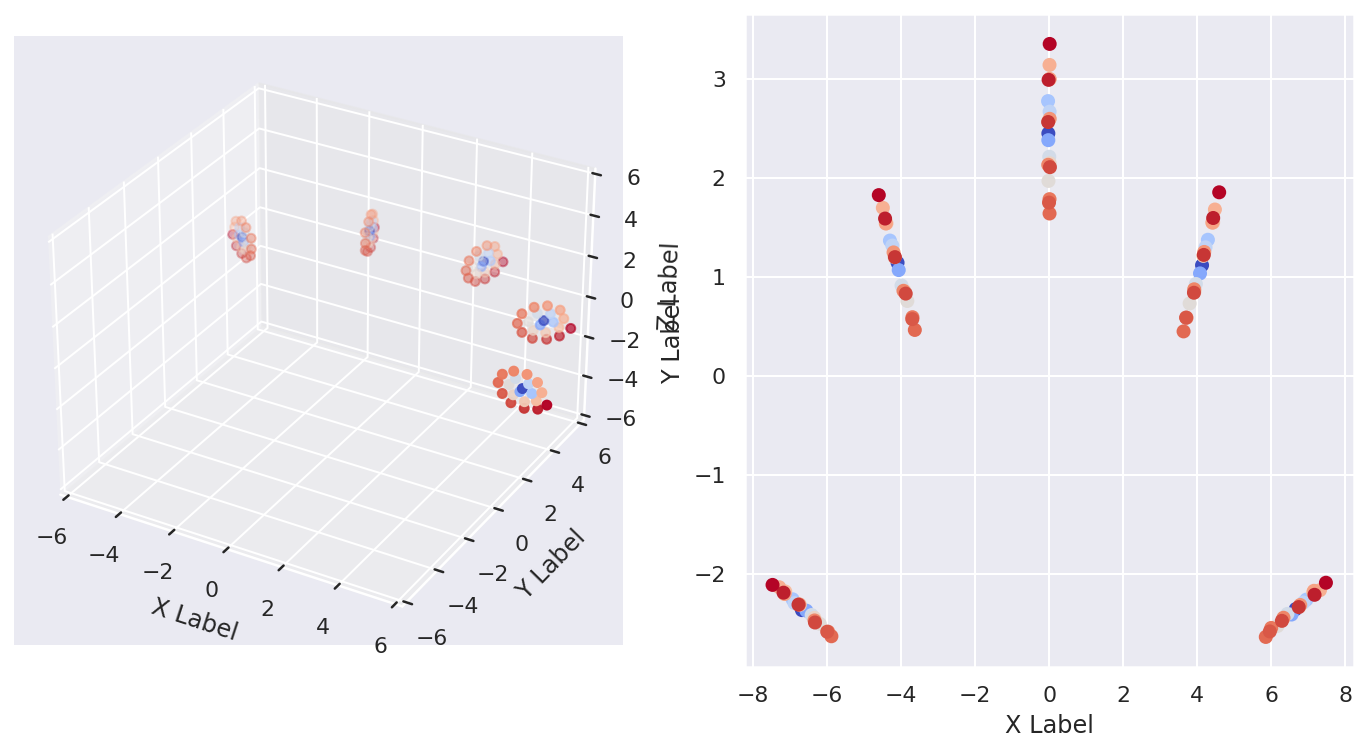

In [12]:
show_KernelPCA()

In [13]:
params={
    "spiral_steps":[100],
    "spiral_density":[0.1, 0.5, 2, 10],
    "width": [1, 3, 9, 15],
    "angle":[0.1, 0.5, 1, 3.14],
    "roll_density":[1,2,3,5,10]
} # eksperymentalnie znalezione ciekawe zakresy, wygenerujmy PCA i kernel PCA

In [ ]:
from itertools import product

keys, values = zip(*params.items())
results = [dict(zip(keys, p)) for p in product(*values)]

for result in results:
  show_PCA(**result)
  show_KernelPCA(**result)

#### MDS implementation

In [17]:
import matplotlib
matplotlib.use('Agg')

In [19]:
import os
def show_MDS(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5):
    if os.path.exists(f'mds_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png'):
        return
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    points_transformed = embedding.fit_transform(points)

    points_transformed_t = points_transformed.T

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'mds_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

In [20]:
for result in results:
  show_MDS(**result)

/home/przemek/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/przemek/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/przemek/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/przemek/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manu

#### t-SNE implementation

In [ ]:
def show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30):
    if os.path.exists('tsne_n{n_neighbors}_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png'):
        return
    fig = plt.figure()
    fig.set_size_inches(12,6)
    x,y,z,d=roll_generator(to_array=False, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d=roll_generator(to_array=True, spiral_density=spiral_density,
                           spiral_steps = spiral_steps, width=width,
                           angle=angle, density=roll_density)

    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric=metric, perplexity=perplexity).fit_transform(points)

    points_transformed_t = points_transformed.T


    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'tsne_n{n_neighbors}_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png', bbox_inches=extent)

In [ ]:
for result in results:
  show_tSNE(**result)

### In this way, you should get a set of images showing the various available projections of the original roulade to the 2D plane. Treat these images as elements of a new data set, we treat image pixels as a high-dimensional vector. Use t-SNE to project the newly created set of 2d projection thumbnails into a 2-dimensional space.

In [ ]:
import cv2
import os

filelist= list(filter(lambda x: x.endswith(".png"), os.listdir('.')))

new_dataset = []
new_dataset_flat = []

for filename in filelist:
    im = cv2.imread(filename, cv2.IMREAD_COLOR)
    new_dataset.append(im)
    im = im.flatten()
    new_dataset_flat.append(im)

new_dataset_flat = np.array(new_dataset_flat)
print(new_dataset_flat.shape)

In [ ]:
from sklearn.manifold import TSNE

new_dataset_2d = TSNE(n_components=2, metric="cosine").fit_transform(new_dataset_flat)
new_dataset_2d.shape

In [ ]:
matplotlib.use('TkAgg')

def imscatter(x, y, image, ax=None, zoom=1):
    ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for idx, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

###   UMAP, TriMAP and PaCMAP

Now, we will use manifold learning for data visualization of large data sets (with high dimensionality).

- UMAP (Uniform Manifold Approximation and Projection) is a relatively recent technique that not only serves as a tool for dimensionality reduction but also for visualization of complex datasets. Unlike t-SNE, UMAP maintains the global structure of the data more effectively, making it superior for general non-linear dimension reduction tasks, with faster computation and better scalability.

- TriMAP is an algorithm that extends the idea of preserving global and local structures of high-dimensional data into lower-dimensional spaces, focusing on retaining the triplet relationship among the data points. It emphasizes keeping an anchor data point closer to a positive point than to a negative point in the reduced dimension, enhancing the ability to maintain both local and global structures compared to t-SNE and UMAP in certain cases.

- PaCMAP (Pairwise Controlled Manifold Approximation and Projection) is a dimensionality reduction method designed to address some of the limitations of t-SNE and UMAP by offering better preservation of the local and global structure with less computational overhead. It operates under a novel framework that explicitly balances the preservation of local and global data relationships, providing an efficient and scalable approach to visualizing high-dimensional data.

In [ ]:
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

ModuleNotFoundError: No module named 'umap'

In [ ]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

In [ ]:
mnist_names = [i for i in range(10)]

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

In [ ]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Design generic experiment (iterate through next methods) and design experiment, where t-SNE, UMAP, TriMAP and PACMAP will project MNIST and FMNIST datasets into a 2-dimensional space (or any dataset of you choice).

In [ ]:
# TODO

#### IMPORTANT: In order to compare the results of methods above:
1) Use metrics script provided as attachment to this lab.
2) Design a $cf_{nn}$ metric using the formula: $cf=\frac{\sum_{{\text{\it nn}}=1}^{{\text{\it nn}}_{\max}}cf_{\text{\it nn}}}{nn_{\max}}$, $cf_{\text{\it nn}}=\frac{\sum_{i=1}^{M}nn(i)}{nn{\cdot} M}$, where $nn(i)$ is the number of nearest neighbors of $y_i$ in the space $Y$, which belong to the same class as $x_i$. The value of $cf$ is calculated for an arbitrarily defined value of $nn_{max}$ depending on the number of feature vectors in the class. To reflect a wide range of embedding properties, we use $nn_{max}=100$. The value of $cf \sim 1$ for well separated and pure classes, while $cf \sim \frac{1}{K}$ for random points in the $K$ class.